In [1]:
from gru.gru_v3 import EncoderDecoder
from gru.dataset import GRUDataset
from gru.cce import ConsciousCrossEntropy
import torch
import torch.nn as nn
import pandas as pd
from vectorizer import SELFIESVectorizer, determine_alphabet

torch.cuda.empty_cache()

model = EncoderDecoder

device = 'cuda'
print(device)

# Set hyperparameters
encoding_size = 512
hidden_size = 512
num_layers = 1
learn_rate = 0.0003
dropout = 0 # dropout must be equal 0 if num_layers = 1
teacher_ratio = 0.5

# Init model
model = EncoderDecoder(
    fp_size=4860,
    encoding_size=encoding_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout,
    teacher_ratio = teacher_ratio).to(device)

alphabet = pd.read_csv('./GRU_data/alphabet.txt', header=None).values.flatten()

#model.load_state_dict(torch.load('PATH'))
model.load_state_dict(torch.load('./models/v3-revisited/model_epoch_14.pt'))

cuda


<All keys matched successfully>

In [2]:
test_df = pd.read_parquet('./GRU_data/test_dataset.parquet').reset_index().drop(columns='index')
vectorizer = SELFIESVectorizer(alphabet, pad_to_len=128)
test_dataset = GRUDataset(test_df, vectorizer)

print("Test size:", len(test_dataset))

from torch.utils.data import DataLoader
batch_size = 256
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, drop_last=True)

x, y = next(iter(test_loader))
x = x.to(device)
y = y.to(device)

Test size: 121524


In [3]:
out = model(x, y, teacher_forcing=False)
softmax = nn.Softmax(dim=2)
out = softmax(out)
out = out.detach().cpu().numpy()
target = y.detach().cpu().numpy()
fps = x.detach().cpu().numpy()

In [4]:
import selfies as sf
import rdkit.Chem as Chem

preds = []
targets = []

preds_selfies = []
targets_selfies = []

for n in range(batch_size):
    selfie_out = vectorizer.devectorize(out[n], remove_special=True)
    preds_selfies.append(selfie_out)
    selfie_target = vectorizer.devectorize(target[n], remove_special=True)
    targets_selfies.append(selfie_target)
    smiles_out = sf.decoder(selfie_out)
    smiles_target = sf.decoder(selfie_target)
    mol_out = Chem.MolFromSmiles(smiles_out)
    mol_target = Chem.MolFromSmiles(smiles_target)
    preds.append(mol_out)
    targets.append(mol_target)

In [5]:
key = pd.read_csv('KlekFP_keys.txt', header=None, names=['smarts'])

In [6]:
 from ipywidgets import interact_manual, interact
import rdkit.Chem.Draw.IPythonConsole as IpythonConsole
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
import numpy as np

IPythonConsole.molSize = 500,500

fps = x.cpu().numpy()

def highlight(idx, fp_bit):
    target_mol = targets[idx]
    pred_mol = preds[idx]
    fp = fps[idx]
    fp_idxised = idxise_fp(fp)
    print(fp_idxised)
    substructure = Chem.MolFromSmarts(key.smarts[fp_bit])
    target_mol.GetSubstructMatches(substructure)
    return(target_mol)
    
def idxise_fp(fp):
    fps_idxised = []
    for i in range(len(fp)):
        if fp[i] == 1:
            fps_idxised.append(i)
    return(fps_idxised)

[296, 340, 343, 604, 609, 620, 1153, 1192, 2124, 2261, 2264, 2974, 3024, 3155, 3156, 3179, 3223, 3335, 3368, 3395, 3397, 3639, 3656, 3658, 3659, 3691, 3705, 3711, 3725, 3728, 3732, 3734, 3739, 3740, 3741, 3749, 3750, 3751, 3755, 3772, 3780, 3781, 3881, 3883, 3888, 3914, 3925, 3941, 4079, 4236, 4273, 4330, 4538]


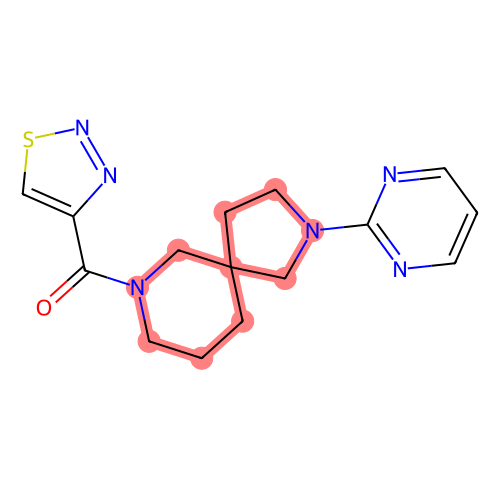

In [11]:
highlight(0, 296) #(molecule number in batch, substructure key)